Here, I use the xgboost model, without the datetime features, to recurssively predict the stock price in the future 21 sdays.

The scaling scheme is the same as the previous xgboost models. The feature space is largely reduced: only date-related features and adj_close (including lags) are used. This is due to the limitation from the recurssive prediciton manner, where the other features in the future are not available. 

In [1]:
import numpy as np
import math
import re

import pandas as pd
#import pandas_datareader as pdr

from datetime import datetime as dt

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

from matplotlib import pyplot as plt
%matplotlib inline 
plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# common setting for all models
ticker = 'FSLR'
splitting = 0.2,0.2 # for valication, testing, and the rest for training
metrics = pd.DataFrame()

def forecast_metrics(y_true, y_pred, algo='Algo'):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = 100 * np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # MAPE
    smape = 200 * np.mean((np.abs(y_pred - y_true)
                    / (np.abs(y_pred) + np.abs(y_true))))
    corr = np.corrcoef(y_pred, y_true)[0,1]   # corr
    mins = np.amin(np.hstack([y_pred[:,None], 
                              y_true[:,None]]), axis=1)
    maxs = np.amax(np.hstack([y_pred[:,None], 
                              y_true[:,None]]), axis=1)
    minmax = 100*(1 - np.mean(mins/maxs))             # minmax
    return pd.DataFrame({'RMSE': rmse,
                         'MAPE': mape,
                         'SMAPE': smape,
                         'MinMax': minmax,
                         'Corr': corr
                        }, index=[algo]
          )

data = pd.read_csv('data/{0}.csv'.format(ticker.lower()), parse_dates=['date'])
data.sort_values(by='date', inplace=True, ascending=True) # not needed, but to make sure

ndata = len(data)
ntest = int(ndata * splitting[-1])
nval = int(ndata * splitting[-2])
ntrain = ndata - ntest - nval
ntrval = ntrain + nval

data.head(5)

,date,high,low,open,close,volume,adj_close
0,2014-01-02,57.580002,54.009998,54.279999,57.439999,5404200,57.439999
1,2014-01-03,58.299999,55.849998,57.590000,56.740002,4118700,56.740002
2,2014-01-06,54.630001,51.009998,54.250000,51.259998,11791700,51.259998
3,2014-01-07,53.889999,52.060001,52.150002,52.490002,6661900,52.490002
4,2014-01-08,52.889999,51.410000,52.290001,51.680000,4930200,51.680000


### Modelling

In [44]:
# functions to wrap lines

def get_mov_avg_std(df, col, N):

    df_out = df.copy()
    df_out[col + '_mean'] = df[col].rolling(window = N, min_periods=1).mean().shift()
    df_out[col + '_std'] = df[col].rolling(window = N, min_periods=1).std().shift()
    
    return df_out


def scale_row(row, feat_mean, feat_std):

    feat_std = 0.001 if feat_std == 0 else feat_std    
    row_scaled = (row-feat_mean) / feat_std
    
    return row_scaled


def recursive_fc(model, target, X_test_scaled, prev_vals, N, H):
    """Recursive forecasting"""
    
    forecast = prev_vals.copy()
    for h in range(H):
        prev_mean, prev_std = np.mean(forecast[-N:]), np.std(forecast[-N:])
        forecast_scaled = (forecast[-N:] - prev_mean) / prev_std

        X = X_test_scaled[h:h+1].copy() # a list
        for i in range(1, N+1):
            X.loc[:, f"{target}_lag_{i}"] = forecast_scaled[-i]
        
        y_pred_scaled = model.predict(X)
        
        # Unscale
        forecast = np.concatenate([forecast, 
                                   np.array((y_pred_scaled * prev_std) + prev_mean).reshape(1,)])
           
    return forecast[-H:]


def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          prev_vals, N, H, \
                          seed=42, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          min_child_weight=1, \
                          subsample=1, \
                          colsample_bytree=1, \
                          colsample_bylevel=1, \
                          gamma=0,
                          name='xgb'):

    model = XGBRegressor(objective='reg:squarederror', # silent=True
                         random_state=seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
    
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)

    # predict
    y_pred = recursive_fc(model, y_test.name, X_test_scaled, prev_vals, N, H)

    m = forecast_metrics(y_test, y_pred, name)
    
    return m, y_pred, model



def forcast_all(
                      df,
                      ntrain, N, H, 
                      cols_to_lag_inp, cols_to_scale_inp, features_inp=(),
                      seed=42,
                      n_estimators=100,
                      max_depth=3,
                      learning_rate=0.1,
                      min_child_weight=1,
                      subsample=1,
                      colsample_bytree=1,
                      colsample_bylevel=1,
                      gamma=0,
                      name='params',
                      return_model=False):

    metrics = pd.DataFrame()
    predictions = []
    cols_to_lag = list(cols_to_lag_inp)
    cols_to_scale = list(cols_to_scale_inp)
    
    # prepare the data:
    data = df.copy()
    cols_not_scale = ['date'] + list(features_inp)
    # get rolling mean and std, add lags
    for col in cols_to_lag:
        data = get_mov_avg_std(data, col, N)
        for i in range(1, N+1):
            data[f'{col}_lag_{i}'] = data[col].shift(i)
            cols_to_scale.append(f'{col}_lag_{i}')

    data.dropna(axis=0, how='any', inplace=True)

    for idata in range(ntrain, len(data)-H+1, int((H+1)/2)):
        train = data[idata-ntrain:idata]
        test = data[idata:idata+H].copy()
    
        scaler = StandardScaler()
        train_scaled = scaler.fit_transform(train[cols_to_scale])

        # Convert the numpy array back into pandas dataframe
        train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
        train_scaled[cols_not_scale] = train.reset_index()[cols_not_scale]

        # Do "local" scaling for test
        test_scaled = test[cols_not_scale]
        for col in cols_to_lag:
            feat_list = [f'{col}_lag_{i}' for i in range(1, N+1)]
            # for test
            temp = test.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
            test_scaled = pd.concat([test_scaled, temp], axis=1)

        # column names of the featuers (list), and target, to make all data columns consistent
        features = list(features_inp) + cols_to_scale[1:]
        features.sort()  # xgboost depends on the order of features, when there are ties
        target = cols_to_scale[0]
    
        # Split into X and y
        # X_train = train[features]
        y_train = train[target]
        # X_test = test[features]
        y_test = test[target]

        X_train_scaled = train_scaled[features]
        y_train_scaled = train_scaled[target]
        X_test_scaled = test_scaled[features]

        prev_vals = y_train.iloc[-N:].to_numpy()
        m, y_pred, model = train_pred_eval_model(
                                              X_train_scaled, \
                                              y_train_scaled, \
                                              X_test_scaled, \
                                              y_test, \
                                              prev_vals, N, H, \
                                              seed=seed,             
                                              n_estimators=n_estimators,
                                              max_depth=max_depth,
                                              learning_rate=learning_rate,
                                              min_child_weight=min_child_weight,
                                              subsample=subsample,
                                              colsample_bytree=colsample_bytree,
                                              colsample_bylevel=colsample_bylevel,
                                              gamma=gamma,
                                              name=(name, idata))

        y_p = y_train.iloc[-1].repeat(H)
        m_p = forecast_metrics(y_test, y_p, (name,idata))
        metrics = metrics.append(m.join(m_p, rsuffix='_p'))
        predictions.append(y_pred)
    
    if return_model: return metrics, predictions, model
    return metrics, predictions


#metrics[[param_label, param2_label]] = pd.DataFrame(metrics.index.to_list()).values
def plot_two_params_tuning(metrics, param_label, param2_label):
    temp= pd.DataFrame(metrics.index.to_list()).values
    metrics[param_label] = temp[:,0]
    metrics[param2_label] = temp[:,1]

    color_list = [
        '#1f77b4',  # muted blue
        '#ff7f0e',  # safety orange
        '#2ca02c',  # cooked asparagus green
        '#d62728',  # brick red
        '#9467bd',  # muted purple
        '#8c564b',  # chestnut brown
        '#e377c2',  # raspberry yogurt pink
        '#7f7f7f',  # middle gray
        '#bcbd22',  # curry yellow-green
        '#17becf'   # blue-teal
    ]

    legend_list = []

    fig,ax=plt.subplots(1,1,figsize=(10,6))
    for i in range(len(param2_list)):
        temp = metrics[metrics[param2_label]==param2_list[i]]
        ax = temp.plot(x=param_label, y='MAPE', color=color_list[i%len(color_list)], marker='s', ax=ax)
        legend_list.append(f"{param2_label}_{param2_list[i]}")

    ax.set_xlabel(param_label)
    ax.set_ylabel("MAPE")
    plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure
    plt.show();

In [4]:
def add_datepart(df, fldname, drop=True, time=False, lower=True):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    if lower: attr = [_.lower() for _ in attr]
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    if lower:
        df[targ_pre + 'elapsed'] = fld.astype(np.int64) // 10 ** 9
    else:
        df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)
        

### Feature Engineering

* Only date-related features are allowed


In [5]:
#data['month'] = data.date.dt.month
#data['dayofweek'] = data.date.dt.dayofweek
add_datepart(data, 'date', drop=False)
#data.drop(['year', 'week', 'day', 'dayofyear', 'elapsed'], axis=1, inplace=True)  # I think these features will cause 1-on-1 mapping
data.drop(['elapsed'], axis=1, inplace=True)

from sklearn.preprocessing import LabelEncoder
data.year = LabelEncoder().fit_transform(data.year)

data.drop(['is_year_start'], axis=1, inplace=True)  # always Holiday

# Get difference between high and low of each day
data['range_hl'] = data['high'] - data['low']
data.drop(['high', 'low'], axis=1, inplace=True)

# Get difference between open and close of each day
data['range_oc'] = data['open'] - data['close']
data.drop(['open', 'close'], axis=1, inplace=True)

data.head()

data_copy = data.copy()

,date,volume,adj_close,year,month,week,day,dayofweek,dayofyear,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,range_hl,range_oc
0,2014-01-02,5404200,57.439999,0,1,1,2,3,2,False,False,False,False,False,3.570004,-3.160000
1,2014-01-03,4118700,56.740002,0,1,1,3,4,3,False,False,False,False,False,2.450001,0.849998
2,2014-01-06,11791700,51.259998,0,1,2,6,0,6,False,False,False,False,False,3.620003,2.990002
3,2014-01-07,6661900,52.490002,0,1,2,7,1,7,False,False,False,False,False,1.829998,-0.340000
4,2014-01-08,4930200,51.680000,0,1,2,8,2,8,False,False,False,False,False,1.480000,0.610001


In [6]:
# initial/dryrun parameters
N = 21
H = 21

seed = 42

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 5                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 0.8                # Subsample ratio of the training instance. default = 1
colsample_bytree = 0.8         # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 0.8          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

In [7]:
# cols_to_lag = "volume adj_close range_hl range_oc".split()
cols_to_lag = ["adj_close"]
cols_to_scale = ["adj_close"]

#cols_date = "month dayofweek is_month_end is_month_start is_quarter_end is_quarter_start ".split()
cols_date = []
#cols_date = "year month week day dayofweek dayofyear is_month_end is_month_start is_quarter_end is_quarter_start ".split()

In [8]:
# fig,ax=plt.subplots(figsize=(10,6))
# for d,s in zip([train, val, test], ['k-', 'c-', 'g-']):
#     ax = d.plot(x='date', y='adj_close', style=s, ax=ax)
# ax.legend(['train', 'validation', 'test'])
# ax.set_xlabel("Date")
# ax.set_ylabel("USD")
# plt.show();

In [9]:
# fig,ax=plt.subplots(figsize=(10,6))
# ax = train_scaled.plot(x='date', y='adj_close', style='k-', ax=ax)
# ax.legend(['train_scaled'])
# ax.set_xlabel("Date")
# ax.set_ylabel("USD (scaled)")
# plt.show();

In [10]:
metrics, predictions = forcast_all(
                       data[:ntrval],
                       ntrain, N, H, 
                       cols_to_lag, cols_to_scale, cols_date,
                       seed=seed,
                       n_estimators=n_estimators,
                       max_depth=max_depth,
                       learning_rate=learning_rate,
                       min_child_weight=min_child_weight,
                       subsample=subsample,
                       colsample_bytree=colsample_bytree,
                       colsample_bylevel=colsample_bylevel,
                       gamma=gamma,
                       name='dryrun' )

m = metrics.mean().to_frame().T.reset_index(drop=True)
print(m)

       RMSE      MAPE     SMAPE    MinMax      Corr    RMSE_p    MAPE_p  \
0  4.460849  6.293249  6.150286  5.743954 -0.065933  4.642511  6.553041   

    SMAPE_p  MinMax_p        Corr_p  
0  6.461425  6.021061  1.797374e-15  


### Tuning N_opt

This will affect the scaling

In [11]:
metrics = pd.DataFrame()
    
cols_to_lag = ["adj_close"]
cols_to_scale = ["adj_close"]
cols_date = [] # "month dayofweek is_month_end is_month_start is_quarter_end is_quarter_start is_year_end".split()

param_label = 'N'
param_list = list(range(2,30))

metrics = pd.DataFrame()
for param in param_list:   
    # Train, predict and eval model
    m, _ = forcast_all(          data[:ntrval],
                                 ntrain, param, H, 
                                 cols_to_lag, cols_to_scale, cols_date,
                                 seed=seed,
                                 n_estimators=n_estimators, 
                                 max_depth=max_depth, 
                                 learning_rate=learning_rate, 
                                 min_child_weight=min_child_weight, 
                                 subsample=subsample, 
                                 colsample_bytree=colsample_bytree, 
                                 colsample_bylevel=colsample_bylevel, 
                                 gamma=gamma,
                                 name=param )

    m_ = m.mean().to_frame().T
    m_[param_label] = m.index[0][0]

    # collect metrics
    metrics = metrics.append(m_)

metrics = metrics.reset_index(drop=True)
metrics

,RMSE,MAPE,SMAPE,MinMax,Corr,RMSE_p,MAPE_p,SMAPE_p,MinMax_p,Corr_p,N
0,4.001247,5.628255,5.594362,5.254921,0.021183,3.911786,5.468569,5.447386,5.122980,1.492079e-15,2
1,4.055407,5.668172,5.643354,5.309751,0.007262,4.138044,5.798778,5.774426,5.445750,-1.196333e-15,3
2,4.147114,5.817976,5.794050,5.457917,0.022260,4.132681,5.848131,5.823973,5.485697,-2.737834e-15,4
3,4.062324,5.664070,5.667157,5.328260,-0.030675,3.935708,5.448670,5.468062,5.137785,1.773078e-15,5
4,3.971650,5.513177,5.531033,5.194268,0.066364,3.936181,5.438917,5.471541,5.143441,-3.762828e-16,6
5,3.783329,5.187910,5.146343,4.857446,0.049519,3.622934,4.905958,4.855651,4.591644,5.694169e-16,7
6,3.706914,5.050728,4.966846,4.685818,0.095463,3.722605,5.063433,4.983280,4.698796,7.880593e-16,8
7,3.977721,5.540350,5.440439,5.109249,-0.031528,4.101081,5.766658,5.680335,5.331103,-2.070498e-16,9
8,4.360542,6.135819,6.018203,5.628690,-0.030030,4.526475,6.418090,6.327464,5.902159,2.165893e-15,10
9,4.294253,6.080768,5.970163,5.586018,0.038826,4.318734,6.118967,6.049542,5.667770,1.412596e-15,11


In [12]:
N_opt = 8 # give the smallest mean MAPE

### Tuning xgboost parameters

In [13]:
cols_to_lag = ["adj_close"]
cols_to_scale = ["adj_close"]
cols_date = [] # "month dayofweek is_month_end is_month_start is_quarter_end is_quarter_start is_year_end".split()

param_label = 'n_estimators'
param_list = [50, 100, 150, 200, 250, 300]

param2_label = 'max_depth'
param2_list = [3, 4, 5, 6, 7, 8, 9]

metrics = pd.DataFrame()
for param in param_list:   
    for param2 in param2_list:
        # Train, predict and eval model
        m, _ = forcast_all(          data[:ntrval],
                                     ntrain, N_opt, H, 
                                     cols_to_lag, cols_to_scale, cols_date,
                                     seed=seed,
                                     n_estimators=param, 
                                     max_depth=param2, 
                                     learning_rate=learning_rate, 
                                     min_child_weight=min_child_weight, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma,
                                     name=(param, param2) )

        m_ = m.mean().to_frame().T
        m_[param_label], m_[param2_label] = m.index[0][0]

        # collect metrics
        metrics = metrics.append(m_)

metrics = metrics.reset_index(drop=True)
metrics

,RMSE,MAPE,SMAPE,MinMax,Corr,RMSE_p,MAPE_p,SMAPE_p,MinMax_p,Corr_p,n_estimators,max_depth
0,3.718413,5.045252,4.974902,4.692517,0.046748,3.722605,5.063433,4.98328,4.698796,7.880593e-16,50,3
1,3.710944,5.044226,4.968126,4.687329,0.037845,3.722605,5.063433,4.98328,4.698796,7.880593e-16,50,4
2,3.736771,5.090158,5.011976,4.729084,0.060190,3.722605,5.063433,4.98328,4.698796,7.880593e-16,50,5
3,3.721836,5.067302,4.986285,4.703967,0.040101,3.722605,5.063433,4.98328,4.698796,7.880593e-16,50,6
4,3.726630,5.074737,4.994207,4.711559,0.061896,3.722605,5.063433,4.98328,4.698796,7.880593e-16,50,7
5,3.707297,5.044866,4.962010,4.680913,0.074502,3.722605,5.063433,4.98328,4.698796,7.880593e-16,50,8
6,3.705308,5.033462,4.951307,4.670810,0.098409,3.722605,5.063433,4.98328,4.698796,7.880593e-16,50,9
7,3.686314,5.015811,4.941489,4.661215,0.071295,3.722605,5.063433,4.98328,4.698796,7.880593e-16,100,3
8,3.686606,5.022861,4.941629,4.662455,0.019064,3.722605,5.063433,4.98328,4.698796,7.880593e-16,100,4
9,3.706914,5.050728,4.966846,4.685818,0.095463,3.722605,5.063433,4.98328,4.698796,7.880593e-16,100,5


In [14]:
metrics.loc[[metrics.MAPE.idxmin()]]
n_estimators_opt, max_depth_opt = metrics.loc[[metrics.MAPE.idxmin()], [param_label, param2_label]].values.flatten()
n_estimators_opt, max_depth_opt

,RMSE,MAPE,SMAPE,MinMax,Corr,RMSE_p,MAPE_p,SMAPE_p,MinMax_p,Corr_p,n_estimators,max_depth
28,3.656233,4.965956,4.876363,4.596958,0.129359,3.722605,5.063433,4.98328,4.698796,7.880593e-16,250,3


(250, 3)

In [15]:
param_label = 'learning_rate'
param_list = [0.1]  # fixed at first

param2_label = 'min_child_weight'
param2_list = range(1, 21, 1)

metrics = pd.DataFrame()
for param in param_list:   
    for param2 in param2_list:
        # Train, predict and eval model
        m, _ = forcast_all(          data[:ntrval],
                                     ntrain, N_opt, H, 
                                     cols_to_lag, cols_to_scale, cols_date,
                                     seed=seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate, 
                                     min_child_weight=param2, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma,
                                     name=(param, param2) )

        m_ = m.mean().to_frame().T
        m_[param_label], m_[param2_label] = m.index[0][0]

        # collect metrics
        metrics = metrics.append(m_)

metrics = metrics.reset_index(drop=True)
metrics

,RMSE,MAPE,SMAPE,MinMax,Corr,RMSE_p,MAPE_p,SMAPE_p,MinMax_p,Corr_p,learning_rate,min_child_weight
0,3.656233,4.965956,4.876363,4.596958,0.129359,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.1,1
1,3.630440,4.920814,4.828792,4.550909,0.141526,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.1,2
2,3.652441,4.950186,4.855585,4.575385,0.086459,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.1,3
3,3.657816,4.960646,4.873097,4.593556,0.119340,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.1,4
4,3.666789,4.997310,4.913663,4.633131,0.120507,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.1,5
5,3.652592,4.966890,4.886263,4.607590,0.095633,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.1,6
6,3.665926,4.986464,4.905745,4.627386,0.083027,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.1,7
7,3.650136,4.958447,4.880001,4.602520,0.121837,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.1,8
8,3.691576,5.034553,4.952685,4.670767,0.045008,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.1,9
9,3.677995,5.008664,4.929805,4.649949,0.090434,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.1,10


In [16]:
metrics.loc[[metrics.MAPE.idxmin()]]
learning_rate_opt, min_child_weight_opt = metrics.loc[[metrics.MAPE.idxmin()], [param_label, param2_label]].values.flatten()

,RMSE,MAPE,SMAPE,MinMax,Corr,RMSE_p,MAPE_p,SMAPE_p,MinMax_p,Corr_p,learning_rate,min_child_weight
1,3.63044,4.920814,4.828792,4.550909,0.141526,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.1,2


In [17]:
# Tuning XGBoost - subsample(default=1) and gamma(default=0)

param_label = 'subsample'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'gamma'
param2_list = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5] # , 0.6, 0.7, 0.8, 0.9, 1]

metrics = pd.DataFrame()
for param in param_list:   
    for param2 in param2_list:
        # Train, predict and eval model
        m, _ = forcast_all(          data[:ntrval],
                                     ntrain, N_opt, H, 
                                     cols_to_lag, cols_to_scale, cols_date,
                                     seed=seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=param, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=param2,
                                     name=(param, param2) )

        m_ = m.mean().to_frame().T
        m_[param_label], m_[param2_label] = m.index[0][0]

        # collect metrics
        metrics = metrics.append(m_)

metrics = metrics.reset_index(drop=True)
metrics

,RMSE,MAPE,SMAPE,MinMax,Corr,RMSE_p,MAPE_p,SMAPE_p,MinMax_p,Corr_p,subsample,gamma
0,3.607652,4.889297,4.800310,4.526481,0.131728,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.5,0.0
1,3.616362,4.898827,4.817027,4.539651,0.031864,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.5,0.1
2,3.696773,5.025353,4.951511,4.670474,0.066335,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.5,0.2
3,3.730184,5.070302,4.999193,4.716129,0.082396,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.5,0.3
4,3.763691,5.117383,5.050771,4.765148,0.088996,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.5,0.4
5,3.774540,5.137821,5.070806,4.783803,0.050884,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.5,0.5
6,3.656903,4.953457,4.861084,4.580532,0.054216,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.6,0.0
7,3.656174,4.964388,4.884124,4.605159,0.117162,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.6,0.1
8,3.695053,5.016563,4.944636,4.665080,0.090832,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.6,0.2
9,3.707334,5.031910,4.960755,4.680389,0.074868,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.6,0.3


In [19]:
metrics.loc[[metrics.MAPE.idxmin()]]
subsample_opt, gamma_opt = metrics.loc[[metrics.MAPE.idxmin()], [param_label, param2_label]].values.flatten()

,RMSE,MAPE,SMAPE,MinMax,Corr,RMSE_p,MAPE_p,SMAPE_p,MinMax_p,Corr_p,subsample,gamma
0,3.607652,4.889297,4.80031,4.526481,0.131728,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.5,0.0


In [20]:
### Tuning XGBoost - colsample_bytree(default=1) and colsample_bylevel(default=1)

param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

metrics = pd.DataFrame()
for param in param_list:   
    for param2 in param2_list:
        # Train, predict and eval model
        m, _ = forcast_all(          data[:ntrval],
                                     ntrain, N_opt, H, 
                                     cols_to_lag, cols_to_scale, cols_date,
                                     seed=seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=subsample_opt, 
                                     colsample_bytree=param, 
                                     colsample_bylevel=param2, 
                                     gamma=gamma_opt,
                                     name=(param, param2) )

        m_ = m.mean().to_frame().T
        m_[param_label], m_[param2_label] = m.index[0][0]

        # collect metrics
        metrics = metrics.append(m_)

metrics = metrics.reset_index(drop=True)
metrics

,RMSE,MAPE,SMAPE,MinMax,Corr,RMSE_p,MAPE_p,SMAPE_p,MinMax_p,Corr_p,colsample_bytree,colsample_bylevel
0,3.803666,5.185063,5.101333,4.810935,0.014305,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.5,0.5
1,3.803666,5.185063,5.101333,4.810935,0.014305,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.5,0.6
2,3.803666,5.185063,5.101333,4.810935,0.014305,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.5,0.7
3,3.681059,5.001986,4.914565,4.636427,0.028066,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.5,0.8
4,3.681059,5.001986,4.914565,4.636427,0.028066,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.5,0.9
5,3.670854,5.008442,4.916299,4.632851,0.017200,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.5,1.0
6,3.803666,5.185063,5.101333,4.810935,0.014305,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.6,0.5
7,3.803666,5.185063,5.101333,4.810935,0.014305,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.6,0.6
8,3.803666,5.185063,5.101333,4.810935,0.014305,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.6,0.7
9,3.681059,5.001986,4.914565,4.636427,0.028066,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.6,0.8


In [21]:
metrics.loc[[metrics.MAPE.idxmin()]]
colsample_bytree_opt, colsample_bylevel_opt = metrics.loc[[metrics.MAPE.idxmin()], [param_label, param2_label]].values.flatten()
colsample_bytree_opt, colsample_bylevel_opt

,RMSE,MAPE,SMAPE,MinMax,Corr,RMSE_p,MAPE_p,SMAPE_p,MinMax_p,Corr_p,colsample_bytree,colsample_bylevel
20,3.607652,4.889297,4.80031,4.526481,0.131728,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.8,0.7


(0.8, 0.7)

In [22]:
N_opt, max_depth_opt, min_child_weight_opt, subsample_opt, colsample_bytree_opt, colsample_bylevel_opt, gamma_opt, n_estimators_opt

(8, 3, 2.0, 0.5, 0.8, 0.7, 0.0, 250)

In [23]:
### Tuning XGBoost - final learning_rate and n_estimators, they should be optimized together

param_label = 'learning_rate'
param_list = [0.01, 0.025, 0.05, 0.1, 0.15, 0.2]

param2_label = 'n_estimators'
param2_list = [100, 150, 200, 250, 300, 350, 400]

metrics = pd.DataFrame()
for param in param_list:   
    for param2 in param2_list:
        # Train, predict and eval model
        m, _ = forcast_all(          data[:ntrval],
                                     ntrain, N_opt, H, 
                                     cols_to_lag, cols_to_scale, cols_date,
                                     seed=seed,
                                     n_estimators=param2, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=param, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=subsample_opt, 
                                     colsample_bytree=colsample_bytree_opt, 
                                     colsample_bylevel=colsample_bylevel_opt, 
                                     gamma=gamma_opt,
                                     name=(param, param2) )
            

        m_ = m.mean().to_frame().T
        m_[param_label], m_[param2_label] = m.index[0][0]

        # collect metrics
        metrics = metrics.append(m_)

metrics = metrics.reset_index(drop=True)
metrics

,RMSE,MAPE,SMAPE,MinMax,Corr,RMSE_p,MAPE_p,SMAPE_p,MinMax_p,Corr_p,learning_rate,n_estimators
0,3.934128,5.410458,5.309025,5.004935,0.086486,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.010,100
1,3.856250,5.264723,5.175179,4.879641,0.044440,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.010,150
2,3.806055,5.182938,5.101216,4.810994,0.044290,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.010,200
3,3.775495,5.133129,5.056307,4.769481,0.050169,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.010,250
4,3.757961,5.107004,5.032170,4.746912,0.068919,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.010,300
5,3.743460,5.088953,5.016830,4.733072,0.037185,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.010,350
6,3.731934,5.073962,5.002712,4.719941,0.021906,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.010,400
7,3.774187,5.131342,5.055248,4.768650,0.079578,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.025,100
8,3.739952,5.091422,5.019514,4.735854,0.001760,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.025,150
9,3.721342,5.065239,4.994575,4.712498,-0.037052,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.025,200


In [24]:
metrics.loc[[metrics.MAPE.idxmin()]]
learning_rate_opt, n_estimators_opt = metrics.loc[[metrics.MAPE.idxmin()], [param_label, param2_label]].values.flatten()
learning_rate_opt, n_estimators_opt

,RMSE,MAPE,SMAPE,MinMax,Corr,RMSE_p,MAPE_p,SMAPE_p,MinMax_p,Corr_p,learning_rate,n_estimators
38,3.566444,4.830508,4.747246,4.47517,0.047868,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.2,250


(0.2, 250.0)

In [29]:
metrics[metrics.learning_rate==0.1].sort_values(by='MAPE')

,RMSE,MAPE,SMAPE,MinMax,Corr,RMSE_p,MAPE_p,SMAPE_p,MinMax_p,Corr_p,learning_rate,n_estimators
24,3.607652,4.889297,4.800310,4.526481,0.131728,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.1,250
26,3.622551,4.913685,4.821554,4.546074,0.114930,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.1,350
23,3.621368,4.915781,4.829030,4.553556,0.167171,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.1,200
22,3.626036,4.921484,4.838745,4.563349,0.136365,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.1,150
25,3.633746,4.932044,4.842368,4.566646,0.088830,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.1,300
21,3.645045,4.952403,4.873272,4.595093,0.135609,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.1,100
27,3.653786,4.976761,4.880381,4.600835,0.072884,3.722605,5.063433,4.98328,4.698796,7.880593e-16,0.1,400


In [39]:
n_estimators_opt = int(n_estimators_opt)

### Final model, test set

In [40]:
#Train, predict and eval model
m, predictions = forcast_all(
                             data,
                             ntrval, N_opt, H, 
                             cols_to_lag, cols_to_scale, cols_date,
                             seed=seed,
                             n_estimators=n_estimators_opt, 
                             max_depth=max_depth_opt, 
                             learning_rate=learning_rate_opt, 
                             min_child_weight=min_child_weight_opt, 
                             subsample=subsample_opt, 
                             colsample_bytree=colsample_bytree_opt, 
                             colsample_bylevel=colsample_bylevel_opt, 
                             gamma=gamma_opt,
                             name='final' )

In [41]:
m.mean().to_frame().T

,RMSE,MAPE,SMAPE,MinMax,Corr,RMSE_p,MAPE_p,SMAPE_p,MinMax_p,Corr_p
0,3.23219,5.277802,5.231819,5.012536,-0.034328,3.26956,5.337565,5.306472,5.07664,-8.271483e-17


### Plotting on test set

In [42]:
m.head(5)
idxs = [x[1] for x in m.index.to_list()]

,RMSE,MAPE,SMAPE,MinMax,Corr,RMSE_p,MAPE_p,SMAPE_p,MinMax_p,Corr_p
"(final, 1188)",4.748359,8.562369,7.932057,7.413941,-0.455911,4.877437,8.928937,8.267240,7.724117,NaN
"(final, 1199)",5.540537,11.804736,10.955233,10.234490,-0.694328,5.239667,11.213209,10.448368,9.795863,NaN
"(final, 1210)",2.445440,5.078031,5.236982,5.078031,0.008064,1.870507,3.654312,3.745686,3.653994,NaN
"(final, 1221)",1.099689,2.111042,2.108990,2.078226,0.209253,1.156395,2.206100,2.193474,2.159321,NaN
"(final, 1232)",3.425758,7.396169,7.074954,6.783816,-0.271727,3.824694,8.375562,7.978493,7.621104,NaN


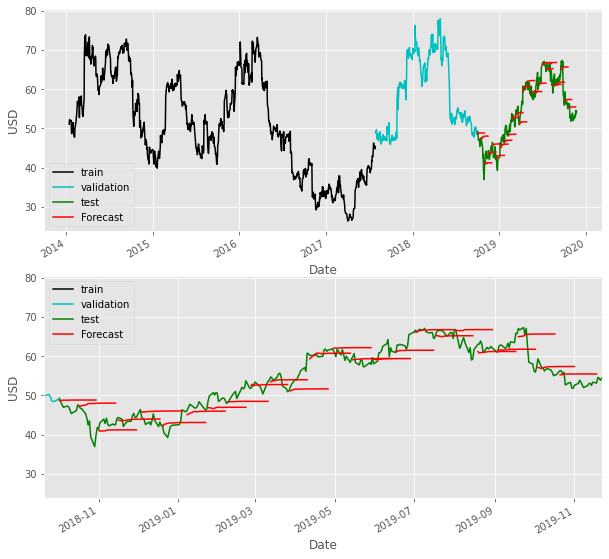

In [43]:
fig,ax=plt.subplots(2,1,figsize=(10,10))

for d,s in zip([ data[N_opt:ntrain+N_opt], data[ntrain+N_opt:ntrval+N_opt], data[ntrval+N_opt:]], ['k-', 'c-', 'g-']):
    ax[0] = d.plot(x='date', y='adj_close', style=s, ax=ax[0])
for i, ist in enumerate(idxs):
    ax[0].plot(data.date[ist+N_opt:ist+H+N_opt],predictions[i], 'r-')
#ax[0].plot(test.date, y_pred, 'r-')
ax[0].legend(['train', 'validation', 'test', 'Forecast'])
ax[0].set_xlabel("Date")
ax[0].set_ylabel("USD")

for d,s in zip([ data[N_opt:ntrain+N_opt], data[ntrain+N_opt:ntrval+N_opt], data[ntrval+N_opt:]], ['k-', 'c-', 'g-']):
    ax[1] = d.plot(x='date', y='adj_close', style=s, ax=ax[1])
for i, ist in enumerate(idxs):
    ax[1].plot(data.date[ist+N_opt:ist+H+N_opt],predictions[i], 'r-')
#ax[0].plot(test.date, y_pred, 'r-')
ax[1].legend(['train', 'validation', 'test', 'Forecast'])
ax[1].set_xlim([data.iloc[ntrval].date, data.iloc[-1].date])
ax[1].set_xlabel("Date")
ax[1].set_ylabel("USD")
#ax[1].text(0.5, 0.5, "Zoomed In")

plt.show();

The prediction is not nice.  
Basically with only these features, we really cannot grasp the trend of the stock price.   
Different models are still struggling to be close or slightly better than the naive persistence model.  
As a result, the most important factor/feature/alpha is simply the stock price of the day before. 
And finding alpha is still a hot topic.

### Single inteval (1H) prediction to show some details 

In [46]:
#Train, predict and eval model
m_1H, predictions_1H, model_1H = forcast_all(
                             data[:ntrval+H+N_opt],
                             ntrval, N_opt, H, 
                             cols_to_lag, cols_to_scale, cols_date,
                             seed=seed,
                             n_estimators=n_estimators_opt, 
                             max_depth=max_depth_opt, 
                             learning_rate=learning_rate_opt, 
                             min_child_weight=min_child_weight_opt, 
                             subsample=subsample_opt, 
                             colsample_bytree=colsample_bytree_opt, 
                             colsample_bylevel=colsample_bylevel_opt, 
                             gamma=gamma_opt,
                             name='final' ,
                             return_model=True)

In [48]:
m_1H.mean().to_frame().T

,RMSE,MAPE,SMAPE,MinMax,Corr,RMSE_p,MAPE_p,SMAPE_p,MinMax_p,Corr_p
0,4.748359,8.562369,7.932057,7.413941,-0.455911,4.877437,8.928937,8.26724,7.724117,NaN


In [57]:
m_1H.head(5)
idxs = [x[1] for x in m_1H.index.to_list()]
predictions_1H

,RMSE,MAPE,SMAPE,MinMax,Corr,RMSE_p,MAPE_p,SMAPE_p,MinMax_p,Corr_p
"(final, 1188)",4.748359,8.562369,7.932057,7.413941,-0.455911,4.877437,8.928937,8.26724,7.724117,NaN


[array([48.69131088, 48.57263947, 48.76375198, 48.77561569, 48.77266312,
        48.77582932, 48.79886246, 48.80756378, 48.81604385, 48.81019211,
        48.80994797, 48.81254578, 48.81298828, 48.81718063, 48.81624603,
        48.81600952, 48.81607056, 48.81600571, 48.81647873, 48.81687546,
        48.81697464])]

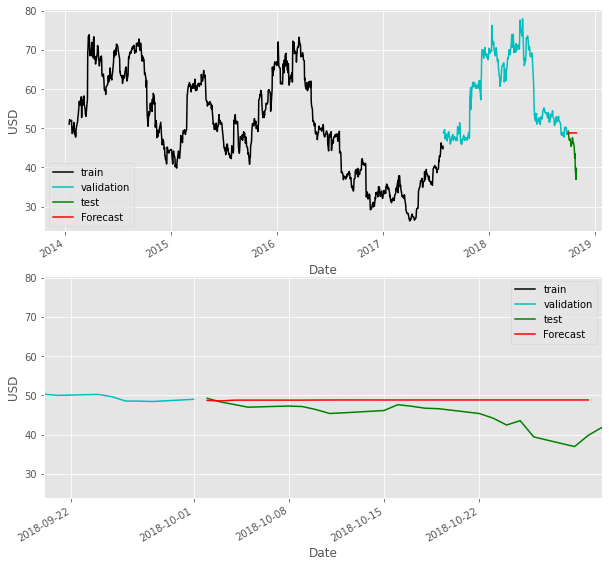

In [59]:
fig,ax=plt.subplots(2,1,figsize=(10,10))

for d,s in zip([ data[N_opt:ntrain+N_opt], data[ntrain+N_opt:ntrval+N_opt], data[ntrval+N_opt:ntrval+N_opt+H]], ['k-', 'c-', 'g-']):
    ax[0] = d.plot(x='date', y='adj_close', style=s, ax=ax[0])
for i, ist in enumerate(idxs):
    ax[0].plot(data.date[ist+N_opt:ist+H+N_opt],predictions_1H[i], 'r-')
#ax[0].plot(test.date, y_pred, 'r-')
ax[0].legend(['train', 'validation', 'test', 'Forecast'])
ax[0].set_xlabel("Date")
ax[0].set_ylabel("USD")

for d,s in zip([ data[N_opt:ntrain+N_opt], data[ntrain+N_opt:ntrval+N_opt], data[ntrval+N_opt:]], ['k-', 'c-', 'g-']):
    ax[1] = d.plot(x='date', y='adj_close', style=s, ax=ax[1])
for i, ist in enumerate(idxs):
    ax[1].plot(data.date[ist+N_opt:ist+H+N_opt],predictions_1H[i], 'r-')
#ax[0].plot(test.date, y_pred, 'r-')
ax[1].legend(['train', 'validation', 'test', 'Forecast'])
ax[1].set_xlim([data.iloc[ntrval].date, data.iloc[ntrval+H+N_opt].date])
ax[1].set_xlabel("Date")
ax[1].set_ylabel("USD")
#ax[1].text(0.5, 0.5, "Zoomed In")

plt.show();

In [64]:
model_1H.feature_importances_

array([0.29834512, 0.10313548, 0.37516758, 0.19445091, 0.00489653,
       0.00515536, 0.00533588, 0.0135132 ], dtype=float32)